In [1]:
# Imports
import sys
from utils.paths import MAIN_DIRECTORY, REL_DATA_DIR
if MAIN_DIRECTORY not in sys.path:
    sys.path.append(MAIN_DIRECTORY)

# Import relevant libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import scripts.models.lstm_oneshot_multistep as lstm
from scripts.models.tcn_oneshot_multistep import MultiStepTCN
from utils.data_preprocessing import (
    create_dataset,
    moving_average_causal_filter,
    normalise_dataset,
    split_train_test_forecast_windows,
)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset
from utils.general_functions import set_seed, set_torch_device
from utils.nn_train import eval_model_on_test_set, train_model
from utils.plotting import plot_example_sample, plot_single_seg_result

# Set random seed and torch device
SEED = 42  # random seed for the dataset and model
set_seed(SEED)
device = set_torch_device()
# device = "cpu" # Manual Override

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [2]:
EXPERIMENTS = [
    "cascadia",
    "p4679",
    "p4581",
    "b726",
    "b698",
    "i417",
    "sim_b726",
    "sim_b698",
    "sim_i417",
]

# Initialize the dataset loader with all experiments and load the data
dataset_loader = SlowEarthquakeDataset(EXPERIMENTS)
dataset_loader.load()

df = {
    exp: dataset_loader.convert_to_df(exp)
    .rename(columns={"seg_avg" if exp == "cascadia" else "obs_shear_stress": "X"})[["X"]]
    for exp in EXPERIMENTS
}

In [5]:
# Define smoothing window and downsampling factor for each experiment (must be integers)
settings = {
    "cascadia": {"smoothing_window": 10, "downsampling_factor": 1},
    "p4679": {"smoothing_window": 13, "downsampling_factor": 13},
    "p4581": {"smoothing_window": 26, "downsampling_factor": 26},
    "b726": {"smoothing_window": 1, "downsampling_factor": 1},
    "b698": {"smoothing_window": 2, "downsampling_factor": 2},
    "i417": {"smoothing_window": 2, "downsampling_factor": 2},
    "sim_b726": {"smoothing_window": 1, "downsampling_factor": 1},
    "sim_b698": {"smoothing_window": 2, "downsampling_factor": 2},
    "sim_i417": {"smoothing_window": 2, "downsampling_factor": 2},
}

# Apply function to every DataFrame in df
df_filtered = {
    exp: moving_average_causal_filter(df[exp], **settings[exp])
    for exp in df
}

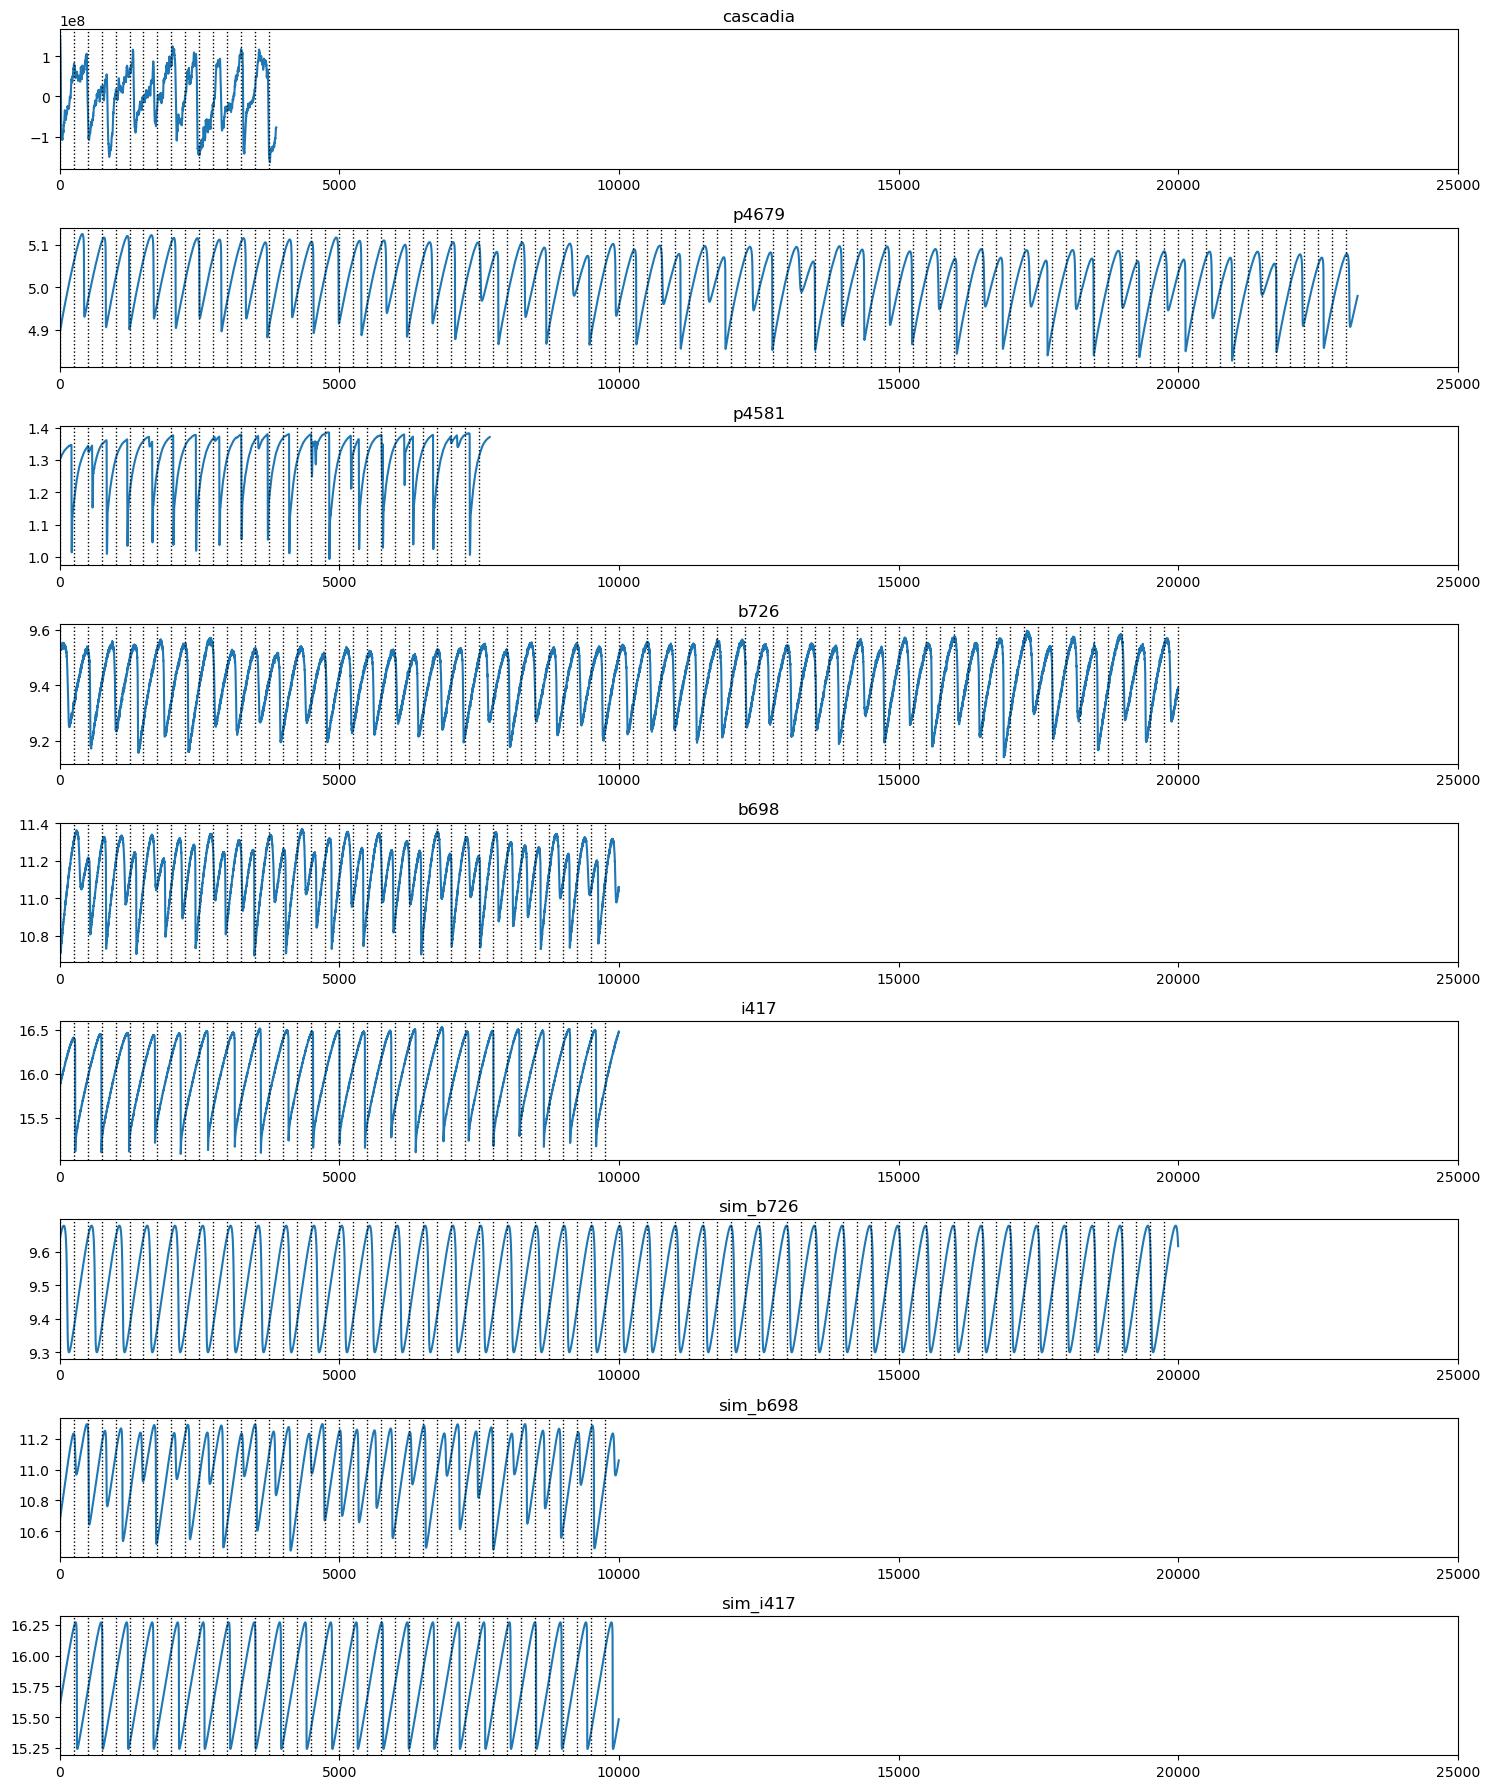

In [14]:
# Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_filtered[exp].reset_index()  # Reset index to ensure 'id' column exists
    sns.lineplot(data=data, x=data.index, y="X")  # Use the DataFrame index for x
    for x in np.arange(0, len(data), 250):
        plt.axvline(x=x, color='black', linestyle=':', linewidth=1)
    plt.title(exp)
    plt.ylabel('')
    plt.xlabel('')
    plt.xlim(0, 25000)
plt.tight_layout()
plt.show()
